In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio

In [ ]:
# Function for loading and preprocessing audio data
def load_and_preprocess_data(data_path, sample_rate=44100, max_length=500):
    data = []
    labels = []

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)

            # Load audio data
            audio_data, _ = librosa.load(file_path, sr=sample_rate)

            # Preprocess and extract features
            features = extract_features(audio_data, sample_rate, max_length)

            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

In [ ]:
# Function for extracting features from audio data
def extract_features(audio_data, sample_rate, max_length):
    # Extract Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Pad or truncate to a fixed length
    if mfccs.shape[1] < max_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]

    return mfccs

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print(f"{model_name} Metrics:")
    print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

    # Display ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Sample Predictions for {model_name}:")
    for i in range(10):  # Display predictions for the first 10 samples
        true_label = label_encoder.inverse_transform([y_test[i]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
        print(f"Sample {i + 1}: True Label - {true_label}, Predicted Label - {pred_label}")


In [ ]:
# Function for plotting training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model {model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [ ]:
# Example usage:
data_folder_path = '/content/drive/MyDrive/Voice'
data, labels = load_and_preprocess_data(data_folder_path)

In [ ]:
# Encode class labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)


In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)


In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled_flattened, y_train_resampled = oversampler.fit_resample(X_train_flattened, y_train)

In [ ]:
X_train_resampled = X_train_resampled_flattened.reshape(X_train_resampled_flattened.shape[0], X_train.shape[1], X_train.shape[2])

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled_flattened, y_train_resampled = undersampler.fit_resample(X_train_resampled_flattened, y_train_resampled)

In [ ]:
X_train_resampled = X_train_resampled_flattened.reshape(X_train_resampled_flattened.shape[0], X_train.shape[1], X_train.shape[2])


In [ ]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_resampled, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Define and compile a simple LSTM model
model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(layers.Dropout(0.3))
model_lstm.add(layers.Dense(num_classes, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define and compile a simple CNN model
model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(layers.MaxPooling1D(3))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(num_classes, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define and compile a model with data augmentation
data_augmentation = models.Sequential([
    layers.GaussianNoise(0.2, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(128),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
data_augmentation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_lstm = model_lstm.fit(X_train_resampled, y_train_one_hot, validation_data=(X_test, y_test_one_hot),epochs=20, batch_size=32, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/20
110/110 [==============================] - 8s 50ms/step - loss: 0.5389 - accuracy: 0.7300 - val_loss: 0.4497 - val_accuracy: 0.8023
Epoch 2/20
110/110 [==============================] - 6s 59ms/step - loss: 0.3455 - accuracy: 0.8594 - val_loss: 0.4280 - val_accuracy: 0.8049
Epoch 3/20
110/110 [==============================] - 5s 49ms/step - loss: 0.2540 - accuracy: 0.9147 - val_loss: 0.4115 - val_accuracy: 0.8166
Epoch 4/20
110/110 [==============================] - 5s 42ms/step - loss: 0.2049 - accuracy: 0.9327 - val_loss: 0.4298 - val_accuracy: 0.8114
Epoch 5/20
110/110 [==============================] - 6s 53ms/step - loss: 0.1858 - accuracy: 0.9338 - val_loss: 0.4339 - val_accuracy: 0.8179
Epoch 6/20
110/110 [==============================] - 7s 62ms/step - loss: 0.1386 - accuracy: 0.9570 - val_loss: 0.4506 - val_accuracy: 0.8205
Epoch 7/20
110/110 [==============================] - 5s 42ms/step - loss: 0.1157 - accuracy: 0.9659 - val_loss: 0.4441 - val_accuracy: 0.8179

In [ ]:
history_cnn = model_cnn.fit(X_train_resampled, y_train_one_hot, validation_data=(X_test, y_test_one_hot),
                            epochs=20, batch_size=32, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/20
110/110 [==============================] - 3s 25ms/step - loss: 24.5600 - accuracy: 0.9089 - val_loss: 4.1222 - val_accuracy: 0.9558
Epoch 2/20
110/110 [==============================] - 3s 24ms/step - loss: 2.6722 - accuracy: 0.9739 - val_loss: 5.0818 - val_accuracy: 0.9454
Epoch 3/20
110/110 [==============================] - 3s 30ms/step - loss: 0.4762 - accuracy: 0.9917 - val_loss: 1.5418 - val_accuracy: 0.9831
Epoch 4/20
110/110 [==============================] - 3s 29ms/step - loss: 0.5627 - accuracy: 0.9923 - val_loss: 1.9389 - val_accuracy: 0.9766
Epoch 5/20
110/110 [==============================] - 3s 23ms/step - loss: 1.5240 - accuracy: 0.9834 - val_loss: 1.7339 - val_accuracy: 0.9818
Epoch 6/20
110/110 [==============================] - 3s 28ms/step - loss: 0.4001 - accuracy: 0.9934 - val_loss: 1.7091 - val_accuracy: 0.9844
Epoch 7/20
110/110 [==============================] - 4s 33ms/step - loss: 0.4888 - accuracy: 0.9920 - val_loss: 0.5799 - val_accuracy: 0.992

In [ ]:
history_augmentation = data_augmentation.fit(X_train_resampled, y_train_one_hot, validation_data=(X_test, y_test_one_hot),
                                             epochs=20, batch_size=32, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/20
110/110 [==============================] - 12s 77ms/step - loss: 0.5583 - accuracy: 0.7225 - val_loss: 0.4557 - val_accuracy: 0.8023
Epoch 2/20
110/110 [==============================] - 5s 48ms/step - loss: 0.3376 - accuracy: 0.8617 - val_loss: 0.4454 - val_accuracy: 0.8088
Epoch 3/20
110/110 [==============================] - 6s 57ms/step - loss: 0.2578 - accuracy: 0.9064 - val_loss: 0.4084 - val_accuracy: 0.8257
Epoch 4/20
110/110 [==============================] - 7s 63ms/step - loss: 0.2020 - accuracy: 0.9273 - val_loss: 0.4101 - val_accuracy: 0.8362
Epoch 5/20
110/110 [==============================] - 5s 47ms/step - loss: 0.1626 - accuracy: 0.9539 - val_loss: 0.4309 - val_accuracy: 0.8427
Epoch 6/20
110/110 [==============================] - 6s 57ms/step - loss: 0.1296 - accuracy: 0.9579 - val_loss: 0.4257 - val_accuracy: 0.8257
Epoch 7/20
110/110 [==============================] - 8s 70ms/step - loss: 0.1057 - accuracy: 0.9699 - val_loss: 0.4280 - val_accuracy: 0.833

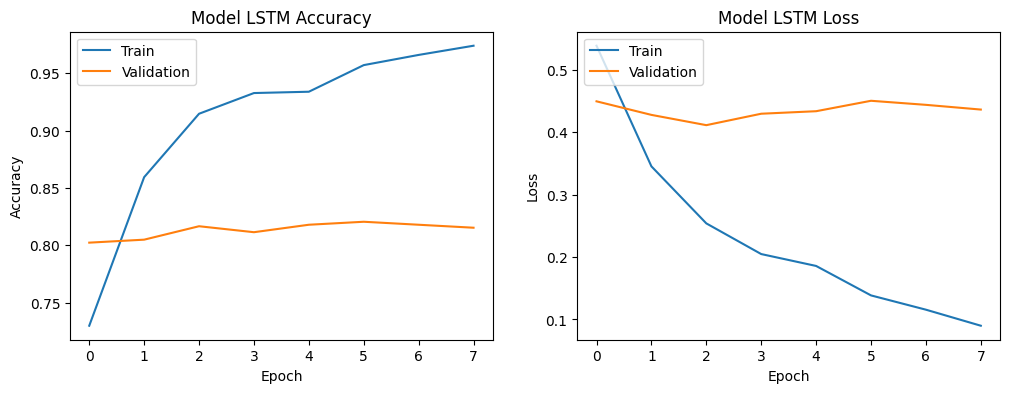

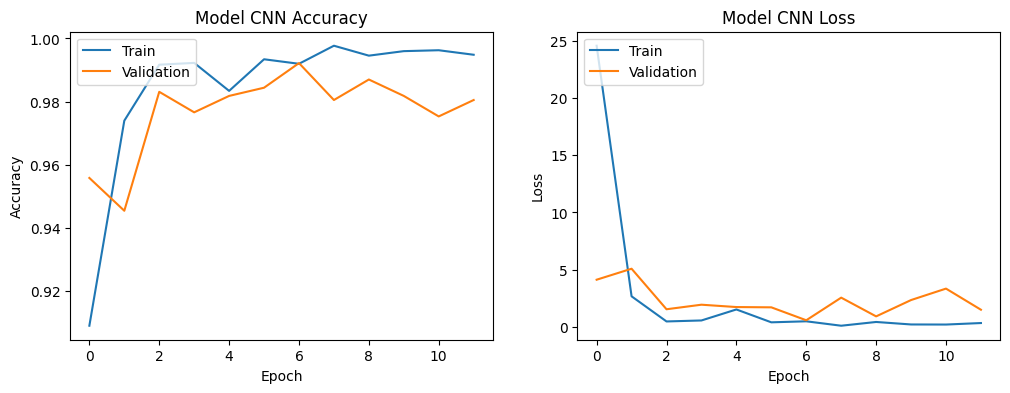

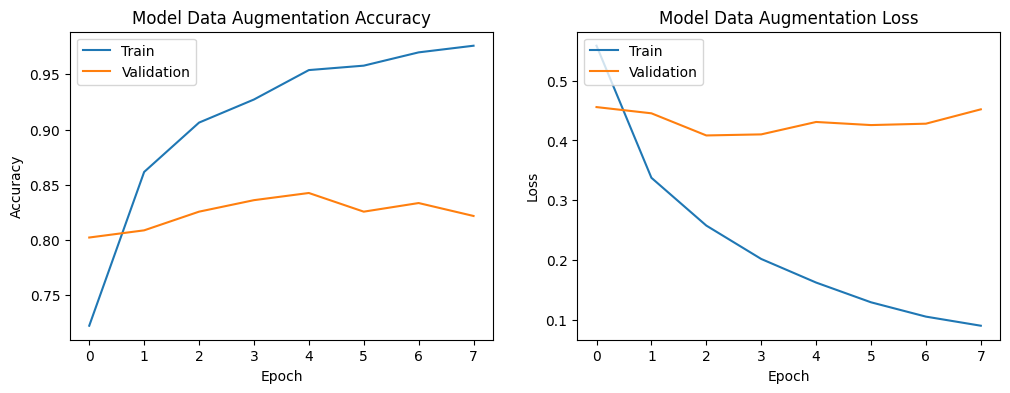

In [ ]:
plot_training_history(history_lstm, 'LSTM')
plot_training_history(history_cnn, 'CNN')
plot_training_history(history_augmentation, 'Data Augmentation')

25/25 [==============================] - 1s 23ms/step
LSTM Metrics:
              precision    recall  f1-score   support

      Female       0.84      0.83      0.84       440
        Male       0.78      0.79      0.79       329

    accuracy                           0.82       769
   macro avg       0.81      0.81      0.81       769
weighted avg       0.82      0.82      0.82       769



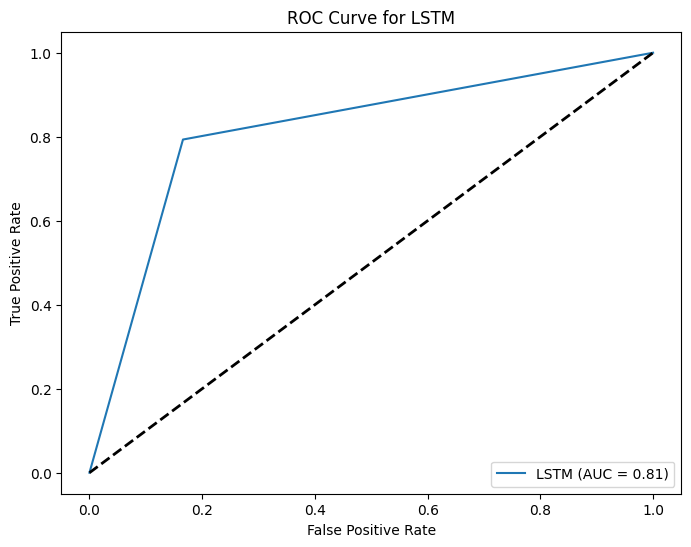

Sample Predictions for LSTM:
Sample 1: True Label - Male, Predicted Label - Male
Sample 2: True Label - Male, Predicted Label - Male
Sample 3: True Label - Female, Predicted Label - Female
Sample 4: True Label - Male, Predicted Label - Female
Sample 5: True Label - Female, Predicted Label - Male
Sample 6: True Label - Female, Predicted Label - Female
Sample 7: True Label - Female, Predicted Label - Male
Sample 8: True Label - Male, Predicted Label - Female
Sample 9: True Label - Male, Predicted Label - Male
Sample 10: True Label - Male, Predicted Label - Male
25/25 [==============================] - 0s 10ms/step
CNN Metrics:
              precision    recall  f1-score   support

      Female       0.99      1.00      0.99       440
        Male       1.00      0.98      0.99       329

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



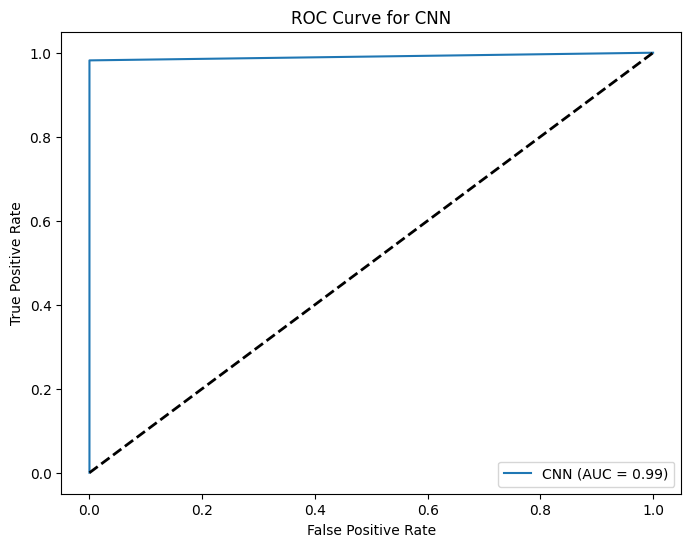

Sample Predictions for CNN:
Sample 1: True Label - Male, Predicted Label - Male
Sample 2: True Label - Male, Predicted Label - Female
Sample 3: True Label - Female, Predicted Label - Female
Sample 4: True Label - Male, Predicted Label - Male
Sample 5: True Label - Female, Predicted Label - Female
Sample 6: True Label - Female, Predicted Label - Female
Sample 7: True Label - Female, Predicted Label - Female
Sample 8: True Label - Male, Predicted Label - Male
Sample 9: True Label - Male, Predicted Label - Male
Sample 10: True Label - Male, Predicted Label - Male
25/25 [==============================] - 1s 23ms/step
Data Augmentation Metrics:
              precision    recall  f1-score   support

      Female       0.84      0.85      0.85       440
        Male       0.80      0.79      0.80       329

    accuracy                           0.83       769
   macro avg       0.82      0.82      0.82       769
weighted avg       0.83      0.83      0.83       769



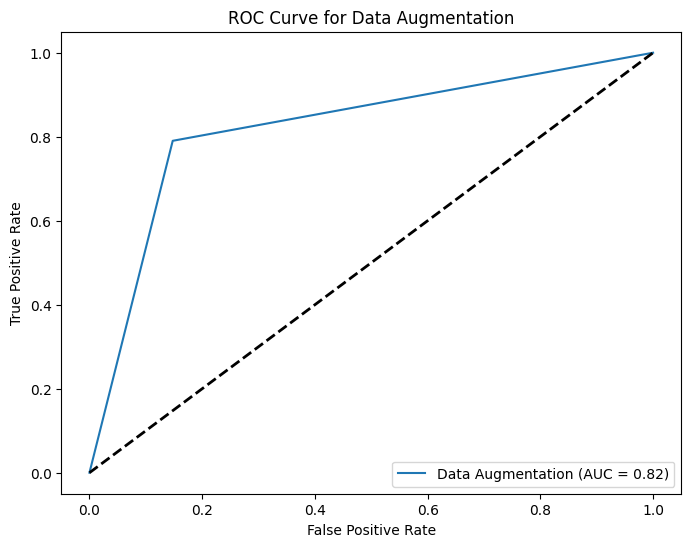

Sample Predictions for Data Augmentation:
Sample 1: True Label - Male, Predicted Label - Male
Sample 2: True Label - Male, Predicted Label - Male
Sample 3: True Label - Female, Predicted Label - Female
Sample 4: True Label - Male, Predicted Label - Male
Sample 5: True Label - Female, Predicted Label - Female
Sample 6: True Label - Female, Predicted Label - Female
Sample 7: True Label - Female, Predicted Label - Female
Sample 8: True Label - Male, Predicted Label - Female
Sample 9: True Label - Male, Predicted Label - Male
Sample 10: True Label - Male, Predicted Label - Male


In [ ]:
evaluate_model(model_lstm, X_test, y_test, 'LSTM')
evaluate_model(model_cnn, X_test, y_test, 'CNN')
evaluate_model(data_augmentation, X_test, y_test, 'Data Augmentation')

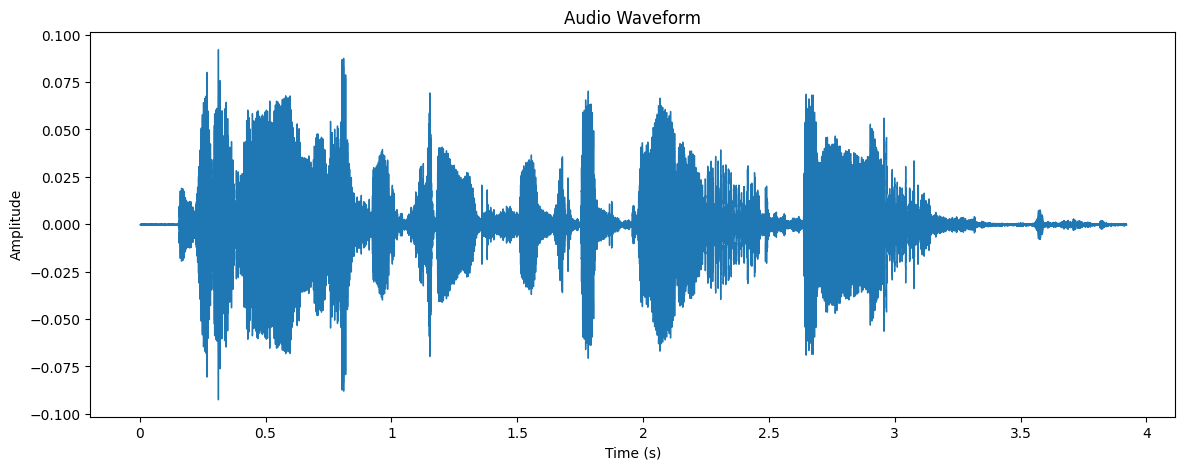

In [ ]:
sample_audio_path = '/content/f0001_us_f0001_00007.wav'
sample_audio, _ = librosa.load(sample_audio_path, sr=44100)
Audio(sample_audio, rate=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_audio, sr=44100)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


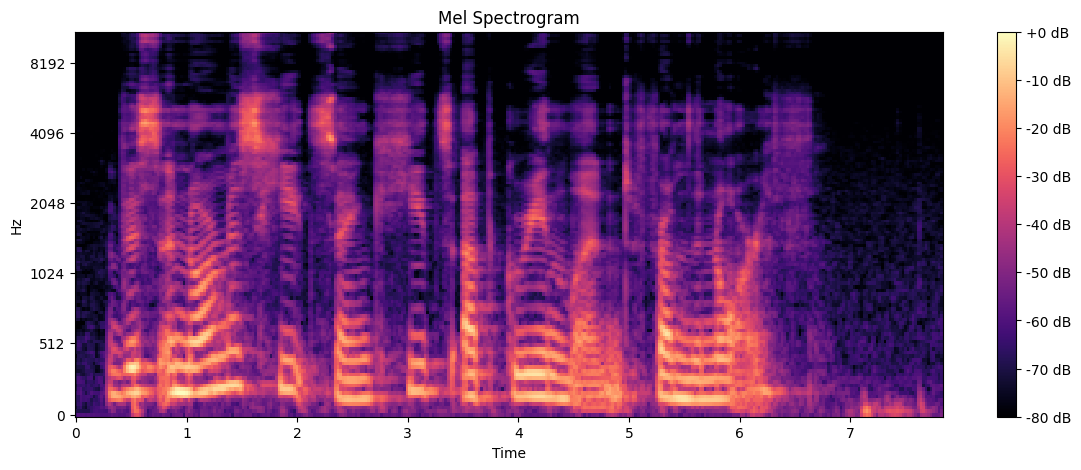

In [ ]:
plt.figure(figsize=(14, 5))
mel_spectrogram = librosa.feature.melspectrogram(y=sample_audio, sr=44100)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

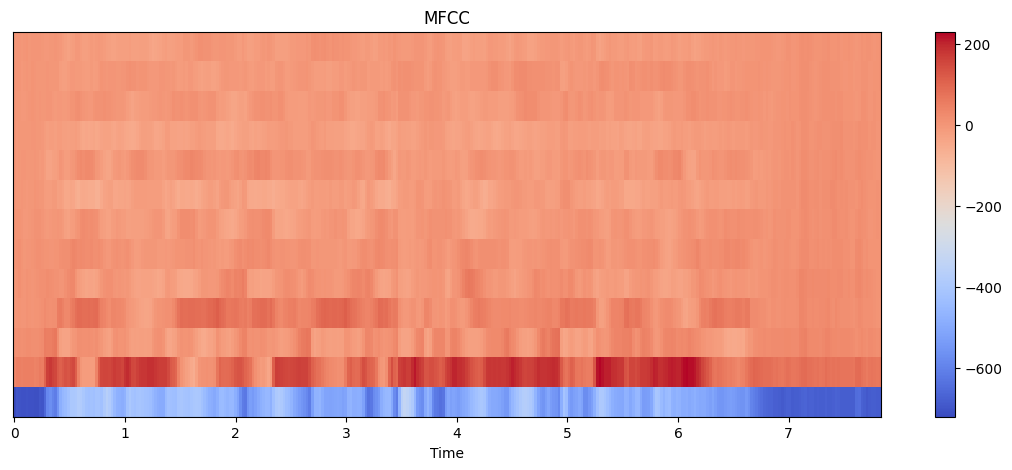

In [ ]:
plt.figure(figsize=(14, 5))
mfccs = librosa.feature.mfcc(y=sample_audio, sr=44100, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()